# Bias de post-tratamiento

> Bias: a systematic distortion of a statistical result due to a factor not allowed for in its derivation.

Es común preocuparse por inferencias erróneas producidas por omitir los predictores suficientes. Este tipo de errores se les llama **bias de omisión de variables**, y lo que vimos en el tema anterior nos da una muestra de lo que puede suceder.

Sin embargo, no es común preocuparse por inferencias erróneas por incluir predictores. Sin embargo, el **bias de inclusión de variables** es real. Meter todas las variables en nuestro modelo no es una buena idea.

Este tipo de bias se puede presentar en varias formas. La primera que veremos es el **bias de post-tratamiento**.

> **Objetivos:**
> - Entender el problema de bias de post-tratamiento.


> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

## 1. Bias de post-tratamiento

La palabra post-tratamiento proviene de la idea de diseño de experimentos.

Supongamos que cultivamos plantas en un invernadero, y queremos saber la diferencia entre cultivarlas bajo los efectos de diferentes fungicidas, dado que los hongos en las plantas suelen reducir su crecimiento.

Inicialmente las plantas son sembradas, y luego brotan, momento en el cual sus tamaños son medidos. Los diferentes tratamientos son llevados a cabo. Después, se miden sus tamaños finales así como la presencia de hongos.

Nuestras variables son entonces:

* Altura inicial
* Altura final -> Resultado
* Tratamiento
* Presencia de hongos

¿Cuáles de estas variables deberíamos incluir en un modelo para predecir la altura final de las plantas? Sucede que si queremos razonar de manera causal, no deberíamos incluir la variable de presencia de hongos, dado que es un efecto post-tratamiento.

Veamos esto con datos simulados:

In [2]:
# Importar scipy.stats norm, binom
from scipy.stats import norm, binom
# Importar numpy
import numpy as np
# Importar pandas
import pandas as pd

In [3]:
binom?

Signature:       binom(*args, **kwds)
Type:            binom_gen
String form:     <scipy.stats._discrete_distns.binom_gen object at 0x7f6e3e28c8e0>
File:            ~/anaconda3/envs/stat-rethink2-pymc_v4/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py
Docstring:      
A binomial discrete random variable.

As an instance of the `rv_discrete` class, `binom` object inherits from it
a collection of generic methods (see below for the full list),
and completes them with details specific for this particular distribution.

Methods
-------
rvs(n, p, loc=0, size=1, random_state=None)
    Random variates.
pmf(k, n, p, loc=0)
    Probability mass function.
logpmf(k, n, p, loc=0)
    Log of the probability mass function.
cdf(k, n, p, loc=0)
    Cumulative distribution function.
logcdf(k, n, p, loc=0)
    Log of the cumulative distribution function.
sf(k, n, p, loc=0)
    Survival function  (also defined as ``1 - cdf``, but `sf` is sometimes more accurate).
logsf(k, n, p, loc=0)
    Log

In [4]:
# Número de plantas
n_plants = 100
# Alturas iniciales
h_start = norm.rvs(size=n_plants, loc=10, scale=2)
# Simulamos tratamiento para la mitad de las plantas
treatment = np.concatenate((
    np.zeros(n_plants // 2),  # No tratamos la mitad de las plantas
    np.ones(n_plants // 2)  # Tratamos la mitad de las plantas
))
# Simulamos presencia de hongos
fungus = binom.rvs(n=1, p=0.5 - treatment * 0.4, size=n_plants)
# Simulamos altura final
h_end = h_start + norm.rvs(size=n_plants, loc=5 - 3 * fungus)
# Dataframe
plants_data = pd.DataFrame({
    "h_start": h_start,
    "treatment": treatment,
    "fungus": fungus,
    "h_end": h_end
})

In [5]:
# método head
plants_data.head()

,h_start,treatment,fungus,h_end
0,12.478084,0.0,1,11.951203
1,9.610992,0.0,1,11.122592
2,10.152015,0.0,0,14.203312
3,12.782609,0.0,1,14.742187
4,9.729578,0.0,0,15.360294


In [6]:
plants_data.describe()

,h_start,treatment,fungus,h_end
count,100.000000,100.000000,100.000000,100.000000
mean,9.995952,0.500000,0.230000,14.293995
std,1.806028,0.502519,0.422953,2.424309
min,4.462073,0.000000,0.000000,8.207842
25%,8.875713,0.000000,0.000000,12.633204
50%,10.004098,0.500000,0.000000,14.595364
75%,11.192790,1.000000,0.000000,15.902851
max,13.925358,1.000000,1.000000,19.583307


Al diseñar el modelo, debemos hacer de cuenta que no conocemos el proceso que genera los datos. En una situación real no conoceremos dicho proceso, más tendremos información científica que nos apoyará en la construcción del modelo.

En este caso, sabemos que las plantas al final serán más altas que al inicio. De esta manera, si modelamos los parámetros de forma proporcional al tamaño de las plantas al inicio, será más fácil razonar acerca de las previas. Enfocándonos en las variables de tamaño:

$$
\begin{array}{ccc}
h_{end, i} & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & h_{start, i} \times p
\end{array}
$$

En este caso, $p$ es la proporción promedio del tamaño final respecto al tamaño inicial:

- Si $p=1$, quiere decir que la planta no creció.
- Si $p=2$, quiere decir que la planta duplicó su tamaño.

De forma que debemos centrar nuestra previa de $p$ en 1, e incluso dejar que $p$ pueda ser menor a 1 (recordemos que no sabemos como se generaron los datos). Sin embargo, debemos asegurar que $p$ sea positiva. Una buena elección es:

$$
p \sim \text{Log-Normal}(0, 0.25)
$$

In [7]:
# Importar scipy.stats lognorm
from scipy.stats import lognorm
# Importar pyplot
from matplotlib import pyplot as plt

In [9]:
lognorm?

Signature:       lognorm(*args, **kwds)
Type:            lognorm_gen
String form:     <scipy.stats._continuous_distns.lognorm_gen object at 0x7f6e3e2657e0>
File:            ~/anaconda3/envs/stat-rethink2-pymc_v4/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py
Docstring:      
A lognormal continuous random variable.

As an instance of the `rv_continuous` class, `lognorm` object inherits from it
a collection of generic methods (see below for the full list),
and completes them with details specific for this particular distribution.

Methods
-------
rvs(s, loc=0, scale=1, size=1, random_state=None)
    Random variates.
pdf(x, s, loc=0, scale=1)
    Probability density function.
logpdf(x, s, loc=0, scale=1)
    Log of the probability density function.
cdf(x, s, loc=0, scale=1)
    Cumulative distribution function.
logcdf(x, s, loc=0, scale=1)
    Log of the cumulative distribution function.
sf(x, s, loc=0, scale=1)
    Survival function  (also defined as ``1 - cdf``, but `sf`

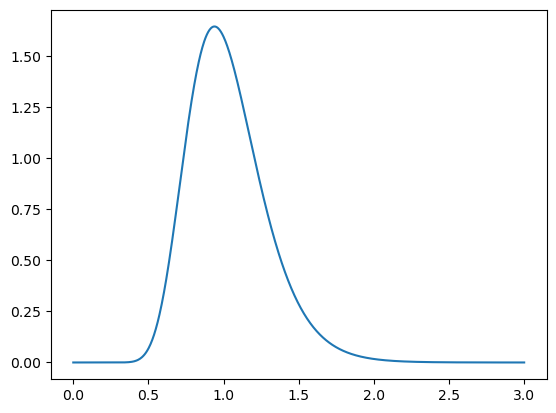

In [11]:
# Densidad log-normal
x = np.linspace(0, 3, 1000)
plt.plot(x, lognorm.pdf(x, loc=0, s=0.25))

Por lo que esta elección espera una reducción desde el 40% hasta un aumente del 50%.

Ajustemos este modelo inicial:

In [12]:
# Importar pymc
import pymc as pm
# Importar arviz
import arviz as az

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [18]:
# Modelo de altura de plantas
with pm.Model() as plant_model:
    sigma = pm.Exponential("sigma", 1)
    p = pm.LogNormal("p", 0, 0.25)
    mu = plants_data["h_start"].values * p
    h_end = pm.Normal("h_end", mu, sigma, observed=plants_data["h_end"])

    idata_plant = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [19]:
# Summary
az.summary(
    idata_plant,
    kind="stats",
    hdi_prob=0.89
)

,mean,sd,hdi_5.5%,hdi_94.5%
sigma,1.991,0.141,1.775,2.218
p,1.412,0.020,1.381,1.444


Se espera un crecimiento promedio del 40%.

Ahora, incluyamos las variables de tratamiento y hongos. Recordemos que los parámetros estarán en la escala de la proporción:

$$
\begin{array}{ccc}
h_{end, i} & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & h_{ini, i} \times p \\
p & = & \alpha + \beta_T t_i + \beta_F f_i \\
\alpha & \sim & \text{Log-Normal}(0, 0.25) \\
\beta_T & \sim & \text{Normal}(0, 0.5) \\
\beta_F & \sim & \text{Normal}(0, 0.5) \\
\sigma  & \sim & \text{Exponential}(1) \\
\end{array}
$$

con esta elección, esperamos con 95% de certeza que que la proporción se reducirá -1 (-100%) o se incrementará +1 (+100%):

In [20]:
# Modelo predictivo
with pm.Model() as predictive_plant_model:
    sigma = pm.Exponential("sigma", 1)
    bf = pm.Normal("bf", 0, 0.5)
    bt = pm.Normal("bt", 0, 0.5)
    a = pm.LogNormal("alpha", 0, 0.25)
    p = (
        a
        + bt * plants_data["treatment"].values
        + bf * plants_data["fungus"].values
    )
    mu = plants_data["h_start"].values * p
    h_end = pm.Normal("h_end", mu, sigma, observed=plants_data["h_end"])

    idata_predictive = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [21]:
# Summary
az.summary(
    idata_predictive,
    kind="stats",
    hdi_prob=0.89
)

,mean,sd,hdi_5.5%,hdi_94.5%
bf,-0.362,0.034,-0.418,-0.309
bt,-0.038,0.030,-0.085,0.008
sigma,1.309,0.094,1.160,1.456
alpha,1.520,0.024,1.481,1.556


El parámetro $\alpha$ es idéntico al que estimamos antes para $p$. La posterior para $b_T$, que representa el efecto del tratamiento es prácticamente cero, lo que nos dice que el tratamiento no está asociado con el creciemiento, lo cual sabemos no es cierto (nosotros construimos los datos). **¿Qué pasó?**

El problema es que la variables indicadora de hongos es una consecuencia directa del tratamiento. Es decir, es una **variable post-tratamiento**. De forma que cuando controlamos (incluimos la variable en el modelo) para los hongos, el modelo está respondiendo la pregunta:

> Una vez sabemos que la planta desarrolló o no hongos, ¿Tiene algún efecto el tratamiento en el crecimiento?

La respuesta es un rotundo **no**, pues el tratamiento impacta el crecimiento a través de reducir los hongos. ¿Qué debemos hacer?

$$
\begin{array}{ccc}
h_{end, i} & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & h_{ini, i} \times p \\
p & = & \alpha + \beta_T t_i \\
\alpha & \sim & \text{Log-Normal}(0, 0.25) \\
\beta_T & \sim & \text{Normal}(0, 0.5) \\
\sigma  & \sim & \text{Exponential}(1) \\
\end{array}
$$

In [22]:
# Modelo de solo el tratamiento
with pm.Model() as predictive_plant_model_2:
    sigma = pm.Exponential("sigma", 1)
    bt = pm.Normal("bt", 0, 0.5)
    a = pm.LogNormal("alpha", 0, 0.25)
    p = (
        a
        + bt * plants_data["treatment"].values
    )
    mu = plants_data["h_start"].values * p
    h_end = pm.Normal("h_end", mu, sigma, observed=plants_data["h_end"])

    idata_predictive_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bt, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [23]:
# Summary
az.summary(
    idata_predictive_2,
    kind="stats",
    hdi_prob=0.89
)

,mean,sd,hdi_5.5%,hdi_94.5%
bt,0.102,0.038,0.043,0.164
sigma,1.936,0.139,1.709,2.152
alpha,1.361,0.027,1.321,1.406


Ahora podemos observar el efecto positivo del tratamiento en el crecimiento de las plantas, como debe de ser. Hace sentido controlar las variables *pre-tratamiento*, como el tamaño inicial, sin embargo, las variables post-tratamiento enmascaran el efecto del tratamiento en sí.

La pregunta es entonces, ¿porqué sucede esto?

Para esto, veamos cuál es el flujo de influencia probabilística a través de un modelo gráfico:

In [24]:
# Importar daft
import daft
# Importar causalgraphicalmodels
from causalgraphicalmodels import CausalGraphicalModel

In [25]:
# Función para dibujar modelos gráficos
def draw_dag(dag, coordinates):
    pgm = daft.PGM()
    for node in dag.dag.nodes:
        pgm.add_node(node, node, *coordinates[node])
    for edge in dag.dag.edges:
        pgm.add_edge(*edge)
    pgm.render()
    plt.gca().invert_yaxis()

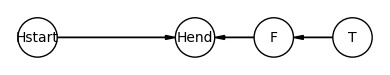

In [28]:
plant_dag = CausalGraphicalModel(
    nodes=["Hstart", "Hend", "F", "T"],
    edges=[("Hstart", "Hend"), ("F", "Hend"), ("T", "F")]
)
coordinates = {"Hstart": (0, 0), "T": (4, 0), "F": (3, 0), "Hend": (2, 0)}

draw_dag(plant_dag, coordinates)

El tratamiento $T$ influencia la presencia de hongos $F$, la cual a su vez influencia el tamaño final de la planta $H_{end}$. El tamaño final de la planta también es influenciado por el tamaño inicial de laplanta $H_{ini}$.

Lo que sucede cuando incluimos la variable de hongos en el modelo es que **bloqueamos** el flujo de influencia probabilística de $T$ hacia $H_{end}$.

In [29]:
plant_dag.get_all_independence_relationships()

[('Hend', 'T', {'F'}),
 ('Hend', 'T', {'F', 'Hstart'}),
 ('T', 'Hstart', set()),
 ('T', 'Hstart', {'F'}),
 ('T', 'Hstart', {'F', 'Hend'}),
 ('Hstart', 'F', set()),
 ('Hstart', 'F', {'T'})]